<a href="https://colab.research.google.com/github/hgrapenthin/EEX-Webscraping/blob/master/Aufgabe_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Komplexe Layerstruktur


## Imports

In [2]:
%tensorflow_version 2.x # Befehl für Google Colab für Tensorflow 2

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # Befehl für Google Colab für Tensorflow 2`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [3]:
# TensorFlow ≥2.0 wird benötigt
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


### Hier werden alle benötigten Keras Klassen importiert, sowie weitere Packages, die für die Ausführung benötigt werden

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Input, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# jupyters notebook Befehl zum direkten Anzeigen von Matplotlib Diagrammen
%matplotlib inline

## Helpers

## Über das `deeplearning2020` python package stellen wir euch folgende helper Funktionen zur Verfügung:

- def plot_learning_curve(title, x, y, y_test, ylim=0.6)
- def plot_history(title, history, ylim=0.6)
- def plot_images(images, labels)

## Zur Nutzung der Funktionen geht ihr folgendermaßen vor:

In [5]:
# Importieren der Helper Function
!pip install --upgrade deeplearning2020

from deeplearning2020 import helpers

#helpers.plot_images(image, class_labels)

     |████████████████████████████████| 399kB 6.7MB/s 
  Created wheel for deeplearning2020: filename=deeplearning2020-0.4.21-py2.py3-none-any.whl size=8548 sha256=dce02d4493870c36041343f48f90d036577ec5288ac97eb91b32e5eda6f1415c
  Stored in directory: /root/.cache/pip/wheels/7f/c2/8a/f9f03fc839999f1fe9d5e5a9d2c97cdd5cb8329f61f82ea2c9
  Created wheel for kerasltisubmission: filename=kerasltisubmission-0.4.9-py2.py3-none-any.whl size=8867 sha256=a325980d1b05a01900feabfa8bdfd131e22c3fdc3356a28f566118210d33688d
  Stored in directory: /root/.cache/pip/wheels/fd/61/f7/09171376b25408ae21b58e98c9fbf2eb924f676bb77659f983
Successfully built deeplearning2020 kerasltisubmission


## Informationen über den Datensatz 

Über `tfds.load` kann man sich neben dem Datensatz selbst auch Informationen über diesen anzeigen 

In [6]:
# Herunterladen des Datensatzes
from deeplearning2020.datasets import ImageWoof

train_data, test_data, classes = ImageWoof.load_data()
# Größe des Trainingsdatensatzes
#dataset_size = info.splits['train'].num_examples

# Größe des Validierungsdatensatzes
#dataset_size_val = info.splits['validation'].num_examples


#print('dataset size val: ', dataset_size_val)

# Informationen über die Klassennamen und Anzahl der Klassen
#class_names = info.features['label'].names
#print('class names: ', class_names)
#n_classes = info.features['label'].num_classes
#print('number of classes: ', n_classes)

328294400/328288506 [==============================] - 7s 0us/step
/root/.keras/datasets/imagewoof2-320/train
Loaded 9025 images
/root/.keras/datasets/imagewoof2-320/val
Loaded 3929 images


Über unsere Helper Funktion kann sich der Datensatz angeschaut werden. Dies ist sinnvoll, um einen Überblick über die vorhandenen Daten zu erhalten. Des Weiteren kann man damit Probleme erkennen, zum Beispiel wenn die Bilder nicht korrekt geladen wurden.

Falls die Daten schon preprocessed wurden (siehe unten) muss `train_data.unbatch().take(9)` aufgerufen werden.

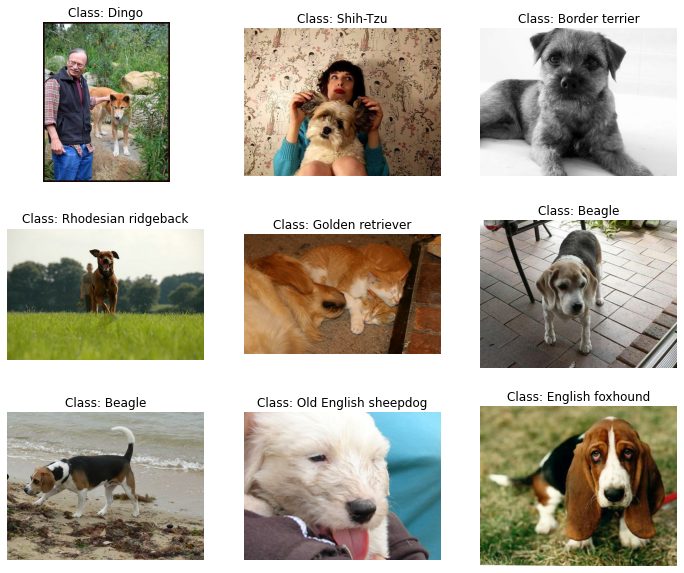

In [7]:
# Anzeigen von 9 Bildern aus dem Trainigsdatensatz
helpers.plot_images(train_data.take(9), classes)

## Preprocessing der Daten

#### Um mit den Bilddaten arbeiten zu können, müssen diese eine einheitliche Größe haben. Dafür stellen wir euch die Funktion `preprocess` bereit, die alle Bilder in die vorgegebene Größe umwandelt


In [0]:
def preprocess(image, label):
    resized_image = tf.image.resize(image/255, [300, 300])
    return resized_image, label

### Laden des Datensatzes


In [9]:
train_data = tfds.load(
    'imagenette/320px',
    split=tfds.Split.TRAIN,
    as_supervised=True
)
test_data = tfds.load(
    'imagenette/320px',
    split=tfds.Split.VALIDATION,
    as_supervised=True
)

# Natürlich lassen sich auf die Trainings und Validation Daten auch über die Variable `data` laden
# Dies kann über data['validation'] und data['train'] passieren.
# Um den Code unabhängig von oben nutzen zu können wurde dies hier noch einmal aufgeführt.

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/imagenette/320px/0.1.0.incompleteT9NCZ6/imagenette-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imagenette/320px/0.1.0.incompleteT9NCZ6/imagenette-validation.tfrecord


Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/320px/0.1.0. Subsequent calls will reuse this data.


## Vorbereitung der Daten zur schnelleren Verarbeitung
Anwendung der `preprocess` Funktion auf alle Daten

`.batch` bereitet den nächsten Batch mit festeglegter Größe vor

`.prefetch` lädt den nächsten Batch schon in den Speicher


In [10]:
# Festlegung der Batch Größe für die Datenvorbereitung
batch_size = 32 

# Durchmischen der Trainingsdaten, dass nicht mit sortierten Bildern trainiert wird 

train_data = train_data.shuffle(1000) 

print('shape des Trainigsdatensatzes vor dem preprocessing: ', train_data)

train_data = train_data.map(preprocess) \
  .batch(batch_size).prefetch(1)          
test_data = test_data.map(preprocess) \
  .batch(batch_size).prefetch(1)

print('shape des Traingingsdatensatzes nach dem preprocessing: ', train_data)

shape des Trainigsdatensatzes vor dem preprocessing:  <DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
shape des Traingingsdatensatzes nach dem preprocessing:  <DatasetV1Adapter shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)>


# Besserer Aufbau des Netzes

Hier wird die Filter Size in den späteren Schichten höher gesetzt. Des Weiteren wurde die Anzahl der Dense Neuronen für die Layer am Ende des Netzes verdoppelt.

Sonst ist das Netzt wie oben aufgebaut.

Damit lassen sich schon bessere Ergebnisse erzielen.

In [11]:
# model
learning_rate=0.0001
momentum=0.9
dense_neurons=1000
n_filters=512
n_classes = 10
first_kernel_size=(7,7)
activation='elu'

# Inputgröße muss 300x300 Pixel mit 3 RGB Farben betragen
input_layer = Input(shape=(300, 300, 3))

# Convolutional Neural Network
# 6 Convolutional Layers mit jeweils einer Max Pooling Layer
model = Conv2D(
    filters=32,
    kernel_size=(3,3),
    activation=activation
)(input_layer)

model = Conv2D(
    filters=32,
    kernel_size=(3,3),
    activation=activation
)(model)

model = Conv2D(
    filters = 256, 
#    filters = 64,
    kernel_size=(3,3), 
    activation=activation
)(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = n_filters, 
#    filters = 128,
    kernel_size=(3,3), 
    activation=activation
)(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = n_filters, 
#    filters = 256,
    kernel_size=(3,3), 
    activation=activation
)(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = n_filters, 
    kernel_size=(3,3), 
    activation=activation
)(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
  filters = n_filters, 
  kernel_size=(3,3), 
  activation=activation, 
  padding='same'
)(model)
model = MaxPooling2D((2,2))(model)

# Fully-Connected-Classifier
model = Flatten()(model)
model = Dense(
    dense_neurons,
    activation=activation
)(model)
model = Dropout(0.5)(model)


model = Dense(
    dense_neurons / 2,
    activation='tanh'
)(model)
model = Dropout(0.5)(model)


# Output Layer
output = Dense(n_classes, activation="softmax")(model)
CNN_model = Model(input_layer, output)

# Kompilieren des Modells
# optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum)
#optimizer = keras.optimizers.RMSprop(lr=learning_rate, momentum=momentum)
optimizer = keras.optimizers.Adam(lr=learning_rate)
CNN_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)
CNN_model.summary()

NameError: ignored

In [0]:
# Training des Modells mit 12 Epochen
history2 = CNN_model.fit(
    train_data,
    epochs=12,
    validation_data=test_data
)

In [0]:
helpers.plot_history('Accuracy zweites CNN', history2, 0)

# Tipps zum Vorgehen

## Tiefe des Netzes

Es ist zum empfehlen, statt einer Layer mit großem Kernel zwei Layer mit kleinerem Kernel zu nutzen. Damit werden trotz der Erweiterung der Tiefe des Netzes weniger Parameter genutzt. 

In [0]:
# Falsch:
model = Conv2D(
    filters=32,
    kernel_size=(7,7),
    activation=activation
)(input_layer)

# Besser:
model = Conv2D(
    filters=32,
    kernel_size=(3,3),
    activation=activation
)(input_layer)
model = Conv2D(
    filters=32,
    kernel_size=(3,3),
    activation=activation
)(model)
# weniger Parameter, weniger Multiplikationen
# aber tieferer Aufbau

## Erste Schicht des Netzes

Hier kann zur Reduktion der Bildgröße ein großer Kernel, wie (7,7) mit strides von (2,2) eingesetz werden

In [0]:
# erste Schicht des Netzes:
model = Conv2D(
    filters=32,
    kernel_size=(7,7),
    strides=(2, 2),
    activation=activation
)(input_layer)
# großer Kernel und großer stride
# dadurch werden große Bilder einfach und gut reduziert

## Wie kann ich weitere Convolutional Layer hinzufügen?

### Reduktion der Bildgröße nicht immer weiter möglich

Da man die Bildgröße nur begrenzt reduzieren kann, sollten am Ende keine Max-Pooling Layer mehr eingesetzt werden. 

Des Weitern muss in den Convolutional Layers `padding` auf `same` gesetzt werden.

![picture](https://drive.google.com/uc?id=1uLjnH_sbtSF7VElnbjuU5G4jXlhsHOT2)

In [0]:
model = Conv2D(
    filters=32,
    kernel_size=(3,3),
    activation=activation,
    padding='same'
)(input_layer)
# keine MaxPoolingschicht mehr
model = Conv2D(
    filters=32,
    kernel_size=(3,3),
    activation=activation,
    padding='same'
)(model)

# Durch praktisches Ausprobieren lernt ihr am besten

Probiert am besten selbst ein wenig herum, mit welchen Konfigurationen des Netzes ihr welche Ergebnisse erzielen könnt.

Diskutiert im Forum, wie ihr das vorgestellte Netz verbessern könnt oder welche Genauigkeiten auf anderen Datensätzen erreicht werden.